In [1]:
import pandas as pd
import numpy as np
from comet_ml import API
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, roc_curve, auc
import pickle5 as pickle
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from sklearn.calibration import calibration_curve
import matplotlib.ticker as mtick
import seaborn as sns







 

In [2]:
def metrics(model, x_test, y_test, model_name, features_name):
    '''
    calculate and log the metrics like: accuracy score for validation
    dataset, confusion matrix, ROC AUC score, ROC curve.
    '''
    pred = model.predict(x_test)
    acc_ex = accuracy_score(y_test,pred)
    #experiment.log_metric(f"validation accuracy {model_name}-{features_name}", acc_ex)
    #experiment.log_confusion_matrix(y_test,pred)
    print(f"Validation Accuracy: {acc_ex}")
    prob_predicted = model.predict_proba(x_test)
    lr_probs = prob_predicted[:,1]
    lr_auc = np.round((roc_auc_score(y_test, lr_probs)),4)
    print(f"ROC AUC:{lr_auc}")
    #experiment.log_metric(f"AUC Score {model}- {features_name} ", lr_auc)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    #experiment.log_curve(f"roc-curve-class-{model}-{features_name}",lr_fpr, lr_tpr)
    #experiment.end()


    return acc_ex, lr_auc, lr_fpr, lr_tpr, lr_probs



    

In [3]:
def plot_gr_perc(lr_probs, y_test):
    df_prob_goals = pd.DataFrame()
    df_prob_goals['y_prob_lr'] = lr_probs
    df_prob_goals['y_test'] = y_test

    d = np.sort(df_prob_goals['y_prob_lr'])
    # Percentile values
    p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0,100.0])
    perc = np.percentile(d, p)

    x = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    y = pd.cut(df_prob_goals['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    y =y.groupby('y_prob_lr', as_index=False).size()
    y.columns = ['y_prob_lr', 'count']

    
    return df_prob_goals, x, y

In [4]:
def plot_partition_perc(df_prob_goals):
    goals = df_prob_goals[df_prob_goals['y_test']==1]

    d = np.sort(goals['y_prob_lr'])
    # Percentile values
    p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])
    perc = np.percentile(d, p)

    x = pd.cut(goals['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    z = len(goals['y_test'])

    return x, z

    

In [5]:
api = API('c2REbE8eQaoRTP059ajV8VYn9')

In [6]:
lr_angle = api.download_registry_model("ift-6758-2",'lr-angle', output_path='./', expand=True)
lr_distance = api.download_registry_model("ift-6758-2",'lr-distance', output_path='./', expand=True)
lr_angle_distance = api.download_registry_model("ift-6758-2",'lr-distance-angle', output_path='./', expand=True)
xgb_5_2 = api.download_registry_model("ift-6758-2",'xgb-model-5-2-pickle','1.0.0', output_path='./', expand=True)
xbg_5_3 = api.download_registry_model("ift-6758-2",'xgb-model-5-3-pickle','1.0.0', output_path='./', expand=True)
svc = api.download_registry_model("ift-6758-2", "model-6-svc-pickle", '1.0.0', output_path='./', expand=True)


COMET INFO: Downloading registry model 'lr-angle', version None, stage None from workspace 'ift-6758-2'...
COMET INFO: Unzipping model to '/Users/minaparham/Desktop/course/Data science/IFT6758-Project/notebooks' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'lr-distance', version None, stage None from workspace 'ift-6758-2'...
COMET INFO: Unzipping model to '/Users/minaparham/Desktop/course/Data science/IFT6758-Project/notebooks' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'lr-distance-angle', version None, stage None from workspace 'ift-6758-2'...
COMET INFO: Unzipping model to '/Users/minaparham/Desktop/course/Data science/IFT6758-Project/notebooks' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'xgb-model-5-2-pickle', version '1.0.0', stage None from workspace 'ift-6758-2'...
COMET INFO: Unzipping model to '/Users/minaparham/Desktop/course/Data science/IFT6758-Project/notebooks' ...
COMET INFO: done!
COMET INFO: Downloading registry mode

In [7]:
df = pd.read_csv('test_2019.csv')
df['is_goal'] = df['is_goal'].astype(np.int64)

df.head()

,Unnamed: 0,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,...,number_friendly,number_opposing,power_play,distance,from_last_distance,angle,last_angle,time_from_last,change_angle,speed
0,0,4,00:25,1,2019020001,Ottawa Senators,Toronto Maple Leafs,1,85.0,-1.0,...,5,5,0,4.1231,85.005882,0.2450,0.0000,25,0.0,0.0
1,1,12,01:31,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-32.0,-2.0,...,5,4,35,57.0351,29.274562,0.0351,0.5292,31,0.0,0.0
2,2,19,03:23,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,63.0,-6.0,...,5,5,0,26.6833,127.015747,0.2268,0.1587,23,0.0,0.0
3,3,22,03:56,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-59.0,-20.0,...,5,5,0,36.0555,93.000000,0.5880,0.3488,56,0.0,0.0
4,4,27,04:47,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-42.0,-29.0,...,5,5,0,55.2268,55.000000,0.5528,0.9273,47,0.0,0.0


In [8]:
df = df.drop(labels='Unnamed: 0', axis=1)
df['game_id'] = df['game_id'].astype(str)
df.head()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,...,number_friendly,number_opposing,power_play,distance,from_last_distance,angle,last_angle,time_from_last,change_angle,speed
0,4,00:25,1,2019020001,Ottawa Senators,Toronto Maple Leafs,1,85.0,-1.0,Tip-In,...,5,5,0,4.1231,85.005882,0.2450,0.0000,25,0.0,0.0
1,12,01:31,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-32.0,-2.0,Snap Shot,...,5,4,35,57.0351,29.274562,0.0351,0.5292,31,0.0,0.0
2,19,03:23,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,63.0,-6.0,Snap Shot,...,5,5,0,26.6833,127.015747,0.2268,0.1587,23,0.0,0.0
3,22,03:56,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-59.0,-20.0,Wrist Shot,...,5,5,0,36.0555,93.000000,0.5880,0.3488,56,0.0,0.0
4,27,04:47,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-42.0,-29.0,Slap Shot,...,5,5,0,55.2268,55.000000,0.5528,0.9273,47,0.0,0.0


In [9]:
df.select_dtypes('object').columns

Index(['period_time', 'game_id', 'team_away_name', 'team_home_name',
       'shot_type', 'strength', 'shooter_name', 'goalie_name', 'team_name',
       'event_type', 'last_type', 'last_period_time'],
      dtype='object')

In [10]:
le = LabelEncoder()
df["shot_type"] = le.fit_transform(df["shot_type"])
df["last_type"] = le.fit_transform(df["last_type"])

In [11]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)


## 7.1

In [12]:
regular_ds = df[df.game_id.str.contains('^201902')]
playoffs_ds = df[df.game_id.str.contains('^201903')]

In [13]:
feature_5 = ['is_goal','period', 'coordinate_x', 'coordinate_y', 'shot_type', 'distance', 'angle', 'last_type', 'last_coord_x', 'last_coord_y', 'time_from_last', 'from_last_distance', 'rebound',
 'change_angle', 'speed','power_play', 'number_friendly', 'number_opposing']
feature_5_2 = ['period', 'coordinate_x', 'coordinate_y', 'shot_type', 'distance', 'angle', 'last_type', 'last_coord_x', 'last_coord_y', 'time_from_last', 'from_last_distance', 'rebound',
 'change_angle', 'speed','power_play', 'number_friendly', 'number_opposing']
feature_5_3 = ['coordinate_x', 'coordinate_y', 'distance', 'angle', 'last_coord_x',
       'last_coord_y', 'time_from_last', 'from_last_distance']
feature_6 = ['is_goal','period', 'coordinate_x', 'coordinate_y', 'empty_net','last_coord_x', 'last_coord_y', 'last_period',
       'number_friendly', 'number_opposing',
       'power_play', 'distance', 'from_last_distance', 'angle', 'last_angle',
       'time_from_last', 'change_angle']
feature_6_svc = ['period', 'coordinate_x', 'coordinate_y', 'empty_net','last_coord_x', 'last_coord_y', 'last_period',
       'number_friendly', 'number_opposing',
       'power_play', 'distance', 'from_last_distance', 'angle', 'last_angle',
       'time_from_last', 'change_angle']

In [14]:
regular_lr = regular_ds[['distance', 'angle', 'is_goal']].dropna().reset_index(drop=True)
playoffs_lr = playoffs_ds[['distance', 'angle', 'is_goal']].dropna().reset_index(drop=True)

regular_xgb = regular_ds[feature_5].dropna().reset_index(drop=True)
playoffs_xgb = playoffs_ds[feature_5].dropna().reset_index(drop=True)

regular_svc = regular_ds[feature_6].dropna().reset_index(drop=True)
playoffs_svc = playoffs_ds[feature_6].dropna().reset_index(drop=True)




In [15]:
#lr-angle:
X_regular_angle = np.array(regular_lr[['angle']])
Y_regular = np.array(regular_lr[['is_goal']])
#lr-distance:
X_regular_distance = np.array(regular_lr[['distance']])
#lr-distance-angle:
X_regular_dist_angle = np.array(regular_lr[['distance','angle']])


In [16]:
#5.2:
Y_regular_xgb = np.array(regular_xgb[['is_goal']])
X_regular_5_2 = np.array(regular_xgb[feature_5_2])
X_regular_5_3 = np.array(regular_xgb[feature_5_3])

In [17]:
#6
Y_regular_svc = np.array(regular_svc[['is_goal']])
X_regular_svc = np.array(regular_svc[feature_6_svc])



In [18]:
#model-lr:
loaded_model_angle = pickle.load(open('lr2_pkl.pickle', 'rb'))
loaded_model_distance = pickle.load(open('lr1_pkl.pickle', 'rb'))
loaded_model_angle_distance = pickle.load(open('lr3_pkl.pickle', 'rb'))
#model-XBG:
model_5_2 = pickle.load(open('model_5_2.pickle', 'rb'))
model_5_3 = pickle.load(open('model_5_3.pickle', 'rb'))
model_6 = pickle.load(open('model_6_svc.pickle', 'rb'))



/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [19]:
#metrices:
#3
acc_ex_lr_angle, auc_lr_angle, fpr_lr_angle, tpr_lr_angle, probs_lr_angle = metrics( loaded_model_angle, X_regular_angle, Y_regular, "XGB", "Distance+Angle")
acc_ex_lr_distance, auc_lr_distance, fpr_lr_distance, tpr_lr_distance, probs_lr_distance = metrics( loaded_model_distance, X_regular_distance, Y_regular, "XGB", "Distance+Angle")
acc_ex_lr_angle_distance, auc_lr_angle_distance, fpr_lr_angle_distance, tpr_lr_angle_distance, probs_lr_angle_distance = metrics( loaded_model_angle_distance, X_regular_dist_angle, Y_regular, "XGB", "Distance+Angle")
# #5
acc_ex_xgb_5_2, auc_xgb_5_2, fpr_xgb_5_2, tpr_xgb_5_2, probs_xgb_5_2 = metrics( model_5_2, X_regular_5_2, Y_regular_xgb, "XGB", "Distance+Angle")
acc_ex_xgb_5_3, auc_xgb_5_3, fpr_xgb_5_3, tpr_xgb_5_3, probs_xgb_5_3 = metrics( model_5_3, X_regular_5_3, Y_regular_xgb, "XGB", "Distance+Angle")
#6
acc_ex_svc, auc_svc, fpr_svc, tpr_svc, probs_svc = metrics( model_6, X_regular_svc, Y_regular_svc, "XGB", "Distance+Angle")




Validation Accuracy: 0.9033993908684904
ROC AUC:0.5508
Validation Accuracy: 0.9033993908684904
ROC AUC:0.7053
Validation Accuracy: 0.9033993908684904
ROC AUC:0.718
Validation Accuracy: 0.9042629857530905
ROC AUC:0.7392
Validation Accuracy: 0.9039580908032596
ROC AUC:0.7192


/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


Validation Accuracy: 0.9071986961686141


/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


ROC AUC:0.5921


In [20]:
#plot_gr_perc
#3
df_prob_goals_lr_angle, x_lr_angle, y_lr_angle = plot_gr_perc(probs_lr_angle, Y_regular)
df_prob_goals_lr_dist, x_lr_dist, y_lr_dist = plot_gr_perc(probs_lr_distance, Y_regular)
df_prob_goals_lr_angle_dist, x_lr_angle_dist, y_lr_angle_dist = plot_gr_perc(probs_lr_angle_distance, Y_regular)
#5
df_prob_goals_xgb_2, x_xgb_2, y_xgb_2 = plot_gr_perc(probs_xgb_5_2, Y_regular_xgb)
df_prob_goals_xgb_3, x_xgb_3, y_xgb_3 = plot_gr_perc(probs_xgb_5_3, Y_regular_xgb)
#6
df_prob_goals_svc, x_svc, y_svc = plot_gr_perc(probs_svc, Y_regular_svc)


In [21]:
#plot_partition_perc
#3
x_partition_lr_angle, z_lr_angle = plot_partition_perc(df_prob_goals_lr_angle)
x_partition_lr_dist, z_lr_dist = plot_partition_perc(df_prob_goals_lr_dist)
x_partition_lr_angle_dist, z_lr_angle_dist = plot_partition_perc(df_prob_goals_lr_angle_dist)

#5
x_partition_xgb_2, z_xgb_2 = plot_partition_perc(df_prob_goals_xgb_2)
x_partition_xgb_3, z_xgb_3 = plot_partition_perc(df_prob_goals_xgb_3)

#6
x_partition_svc, z_svc = plot_partition_perc(df_prob_goals_svc)


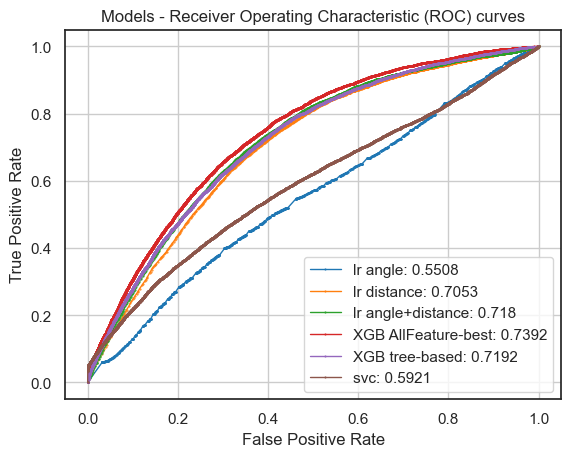

In [27]:
#PLOT1

plt.plot(fpr_lr_angle, tpr_lr_angle, marker='.', linewidth=1, markersize=1,label=f"lr angle: {auc_lr_angle}")
plt.plot(fpr_lr_distance, tpr_lr_distance, marker='.', linewidth=1, markersize=1,label=f"lr distance: {auc_lr_distance}")
plt.plot(fpr_lr_angle_distance, tpr_lr_angle_distance, marker='.', linewidth=1, markersize=1,label=f"lr angle+distance: {auc_lr_angle_distance}")
plt.plot(fpr_xgb_5_2, tpr_xgb_5_2, marker='.', linewidth=1, markersize=1,label=f"XGB AllFeature-best: {auc_xgb_5_2}")
plt.plot(fpr_xgb_5_3, tpr_xgb_5_3, marker='.', linewidth=1, markersize=1,label=f"XGB tree-based: {auc_xgb_5_3}")
#6
plt.plot(fpr_svc, tpr_svc, marker='.', linewidth=1, markersize=1,label=f"svc: {auc_svc}")



plt.title('Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
          

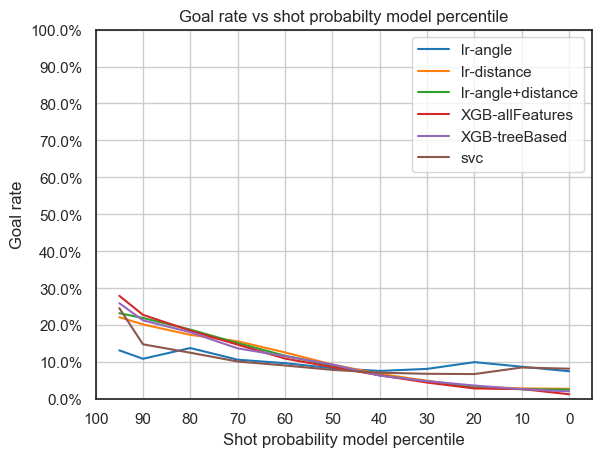

In [23]:
#Plot2
sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lr_angle['count'] / y_lr_angle['count']), label = f'lr-angle')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lr_dist['count'] / y_lr_dist['count']), label = f'lr-distance')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lr_angle_dist['count'] / y_lr_angle_dist['count']), label = f'lr-angle+distance')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_xgb_2['count'] / y_xgb_2['count']), label = f'XGB-allFeatures')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_xgb_3['count'] / y_xgb_3['count']), label = f'XGB-treeBased')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_svc['count'] / y_svc['count']), label = f'svc')

plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
#ax.set_yscale('prob')
fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()

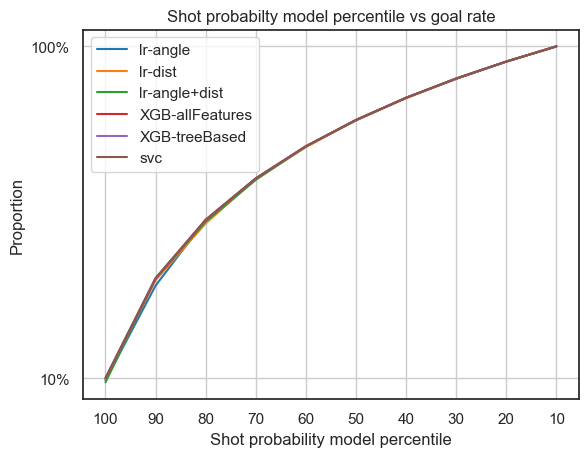

In [25]:
#plot3
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lr_angle['count']/z_lr_angle))).cumsum(), label = 'lr-angle')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lr_dist['count']/z_lr_dist))).cumsum(), label = 'lr-dist')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lr_angle_dist['count']/z_lr_angle_dist))).cumsum(), label = 'lr-angle+dist')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_xgb_2['count']/z_xgb_2))).cumsum(), label = 'XGB-allFeatures')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_xgb_3['count']/z_xgb_3))).cumsum(), label = 'XGB-treeBased')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_svc['count']/z_svc))).cumsum(), label = 'svc')


plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

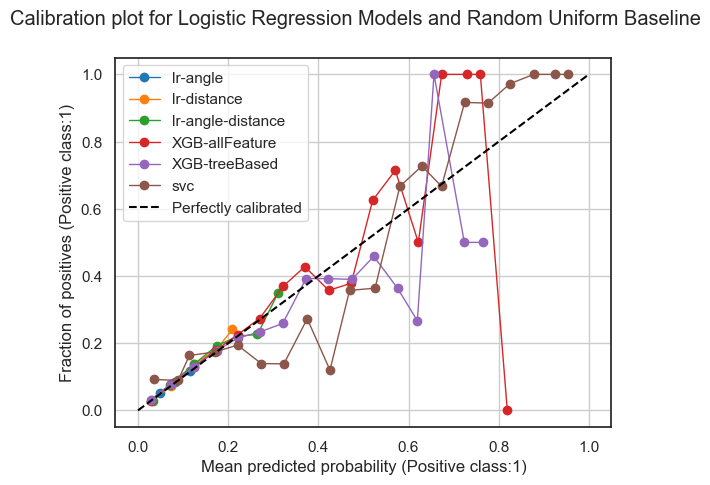

In [26]:
#plot4
lr_angle_y, lr_angle_x = calibration_curve(Y_regular, probs_lr_angle, n_bins=20)
lr_distance_y, lr_distance_x = calibration_curve(Y_regular, probs_lr_distance, n_bins=20)
lr_angle_distance_y, lr_angle_disntace_x = calibration_curve(Y_regular, probs_lr_angle_distance, n_bins=20)

xgb_2_y, xgb_2_x = calibration_curve(Y_regular_xgb, probs_xgb_5_2, n_bins=20)
xgb_3_y, xgb_3_x = calibration_curve(Y_regular_xgb, probs_xgb_5_3, n_bins=20)

svc_y, svc_x = calibration_curve(Y_regular_svc, probs_svc, n_bins=20)







fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(lr_angle_x,lr_angle_y, marker='o', linewidth=1, label='lr-angle')
plt.plot(lr_distance_x,lr_distance_y, marker='o', linewidth=1, label='lr-distance')
plt.plot(lr_angle_disntace_x,lr_angle_distance_y, marker='o', linewidth=1, label='lr-angle-distance')
plt.plot(xgb_2_x,xgb_2_y, marker='o', linewidth=1, label='XGB-allFeature')
plt.plot(xgb_3_x,xgb_3_y, marker='o', linewidth=1, label='XGB-treeBased')
plt.plot(svc_x,svc_y, marker='o', linewidth=1, label='svc')


# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

## 7.2

In [28]:
#lr-angle:
X_playoffs_angle = np.array(playoffs_lr[['angle']])
Y_playoffs = np.array(playoffs_lr[['is_goal']])
#lr-distance:
X_playoffs_distance = np.array(playoffs_lr[['distance']])
#lr-distance-angle:
X_playoffs_dist_angle = np.array(playoffs_lr[['distance','angle']])


In [29]:
#5.2:
Y_playoffs_xgb = np.array(playoffs_xgb[['is_goal']])
X_playoffs_5_2 = np.array(playoffs_xgb[feature_5_2])
X_playoffs_5_3 = np.array(playoffs_xgb[feature_5_3])

In [30]:
#6
Y_playoffs_svc = np.array(playoffs_svc[['is_goal']])
X_playoffs_svc = np.array(playoffs_svc[feature_6_svc])



In [32]:
#metrices:
#3
acc_ex_lr_angle, auc_lr_angle, fpr_lr_angle, tpr_lr_angle, probs_lr_angle = metrics( loaded_model_angle, X_playoffs_angle, Y_playoffs, "XGB", "Distance+Angle")
acc_ex_lr_distance, auc_lr_distance, fpr_lr_distance, tpr_lr_distance, probs_lr_distance = metrics( loaded_model_distance, X_playoffs_distance, Y_playoffs, "XGB", "Distance+Angle")
acc_ex_lr_angle_distance, auc_lr_angle_distance, fpr_lr_angle_distance, tpr_lr_angle_distance, probs_lr_angle_distance = metrics( loaded_model_angle_distance, X_playoffs_dist_angle, Y_playoffs, "XGB", "Distance+Angle")
# #5
acc_ex_xgb_5_2, auc_xgb_5_2, fpr_xgb_5_2, tpr_xgb_5_2, probs_xgb_5_2 = metrics( model_5_2, X_playoffs_5_2, Y_playoffs_xgb, "XGB", "Distance+Angle")
acc_ex_xgb_5_3, auc_xgb_5_3, fpr_xgb_5_3, tpr_xgb_5_3, probs_xgb_5_3 = metrics( model_5_3, X_playoffs_5_3, Y_playoffs_xgb, "XGB", "Distance+Angle")
#6
acc_ex_svc, auc_svc, fpr_svc, tpr_svc, probs_svc = metrics( model_6, X_playoffs_svc, Y_playoffs_svc, "XGB", "Distance+Angle")




Validation Accuracy: 0.9242658423493045
ROC AUC:0.5971
Validation Accuracy: 0.9242658423493045
ROC AUC:0.7625
Validation Accuracy: 0.9242658423493045
ROC AUC:0.7802
Validation Accuracy: 0.9225908372827805
ROC AUC:0.7849
Validation Accuracy: 0.9225908372827805
ROC AUC:0.7791


/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


Validation Accuracy: 0.9225908372827805


/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


ROC AUC:0.6091


In [33]:
#plot_gr_perc
#3
df_prob_goals_lr_angle, x_lr_angle, y_lr_angle = plot_gr_perc(probs_lr_angle, Y_playoffs)
df_prob_goals_lr_dist, x_lr_dist, y_lr_dist = plot_gr_perc(probs_lr_distance, Y_playoffs)
df_prob_goals_lr_angle_dist, x_lr_angle_dist, y_lr_angle_dist = plot_gr_perc(probs_lr_angle_distance, Y_playoffs)
#5
df_prob_goals_xgb_2, x_xgb_2, y_xgb_2 = plot_gr_perc(probs_xgb_5_2, Y_playoffs_xgb)
df_prob_goals_xgb_3, x_xgb_3, y_xgb_3 = plot_gr_perc(probs_xgb_5_3, Y_playoffs_xgb)
#6
df_prob_goals_svc, x_svc, y_svc = plot_gr_perc(probs_svc, Y_playoffs_svc)


In [34]:
#plot_partition_perc
#3
x_partition_lr_angle, z_lr_angle = plot_partition_perc(df_prob_goals_lr_angle)
x_partition_lr_dist, z_lr_dist = plot_partition_perc(df_prob_goals_lr_dist)
x_partition_lr_angle_dist, z_lr_angle_dist = plot_partition_perc(df_prob_goals_lr_angle_dist)

#5
x_partition_xgb_2, z_xgb_2 = plot_partition_perc(df_prob_goals_xgb_2)
x_partition_xgb_3, z_xgb_3 = plot_partition_perc(df_prob_goals_xgb_3)

#6
x_partition_svc, z_svc = plot_partition_perc(df_prob_goals_svc)


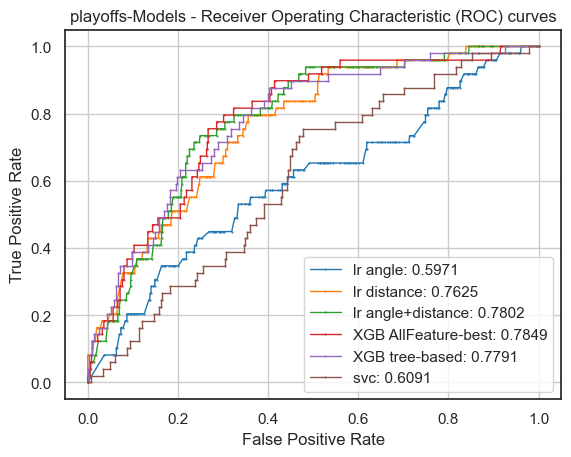

In [35]:
#PLOT1

plt.plot(fpr_lr_angle, tpr_lr_angle, marker='.', linewidth=1, markersize=1,label=f"lr angle: {auc_lr_angle}")
plt.plot(fpr_lr_distance, tpr_lr_distance, marker='.', linewidth=1, markersize=1,label=f"lr distance: {auc_lr_distance}")
plt.plot(fpr_lr_angle_distance, tpr_lr_angle_distance, marker='.', linewidth=1, markersize=1,label=f"lr angle+distance: {auc_lr_angle_distance}")
plt.plot(fpr_xgb_5_2, tpr_xgb_5_2, marker='.', linewidth=1, markersize=1,label=f"XGB AllFeature-best: {auc_xgb_5_2}")
plt.plot(fpr_xgb_5_3, tpr_xgb_5_3, marker='.', linewidth=1, markersize=1,label=f"XGB tree-based: {auc_xgb_5_3}")
#6
plt.plot(fpr_svc, tpr_svc, marker='.', linewidth=1, markersize=1,label=f"svc: {auc_svc}")



plt.title('playoffs-Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
          

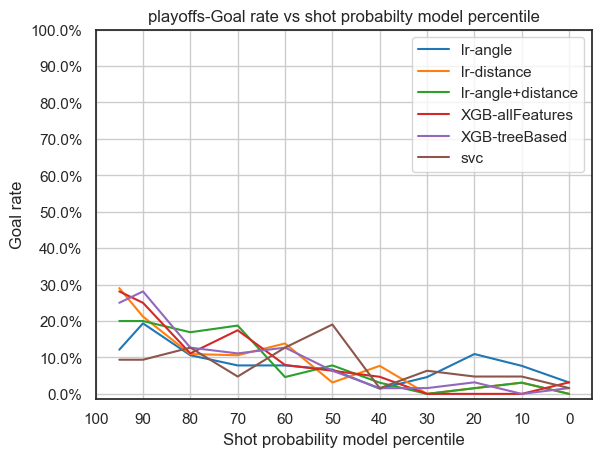

In [36]:
#Plot2
sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lr_angle['count'] / y_lr_angle['count']), label = f'lr-angle')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lr_dist['count'] / y_lr_dist['count']), label = f'lr-distance')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lr_angle_dist['count'] / y_lr_angle_dist['count']), label = f'lr-angle+distance')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_xgb_2['count'] / y_xgb_2['count']), label = f'XGB-allFeatures')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_xgb_3['count'] / y_xgb_3['count']), label = f'XGB-treeBased')
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_svc['count'] / y_svc['count']), label = f'svc')

plt.title('playoffs-Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
#ax.set_yscale('prob')
fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()

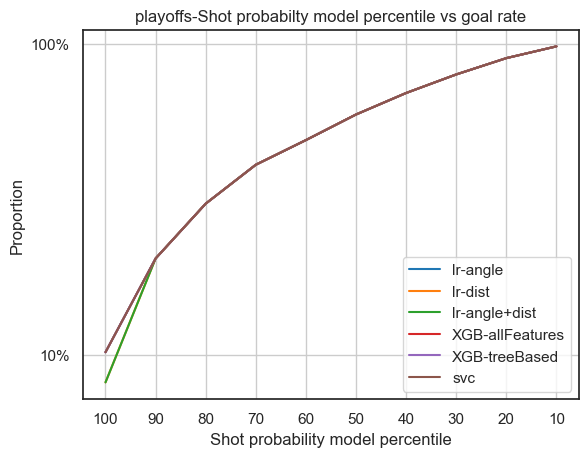

In [37]:
#plot3
#plot3
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lr_angle['count']/z_lr_angle))).cumsum(), label = 'lr-angle')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lr_dist['count']/z_lr_dist))).cumsum(), label = 'lr-dist')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lr_angle_dist['count']/z_lr_angle_dist))).cumsum(), label = 'lr-angle+dist')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_xgb_2['count']/z_xgb_2))).cumsum(), label = 'XGB-allFeatures')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_xgb_3['count']/z_xgb_3))).cumsum(), label = 'XGB-treeBased')
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_svc['count']/z_svc))).cumsum(), label = 'svc')


plt.title('playoffs-Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

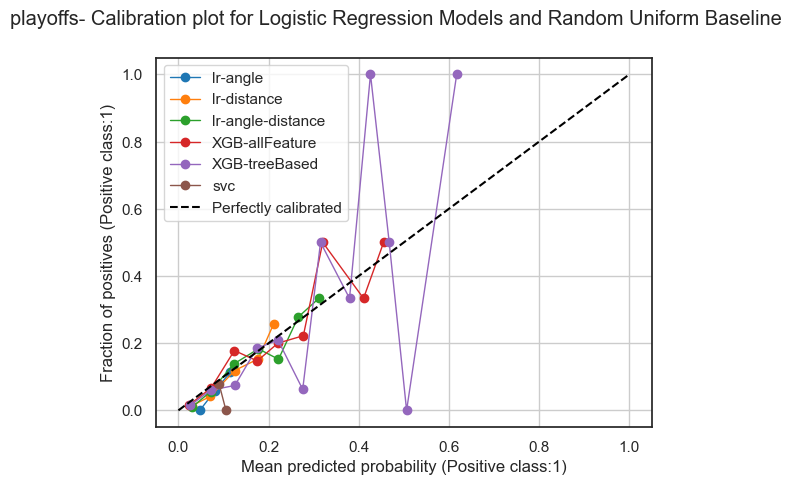

In [39]:
#plot4
lr_angle_y, lr_angle_x = calibration_curve(Y_playoffs, probs_lr_angle, n_bins=20)
lr_distance_y, lr_distance_x = calibration_curve(Y_playoffs, probs_lr_distance, n_bins=20)
lr_angle_distance_y, lr_angle_disntace_x = calibration_curve(Y_playoffs, probs_lr_angle_distance, n_bins=20)

xgb_2_y, xgb_2_x = calibration_curve(Y_playoffs_xgb, probs_xgb_5_2, n_bins=20)
xgb_3_y, xgb_3_x = calibration_curve(Y_playoffs_xgb, probs_xgb_5_3, n_bins=20)

svc_y, svc_x = calibration_curve(Y_playoffs_svc, probs_svc, n_bins=20)




fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(lr_angle_x,lr_angle_y, marker='o', linewidth=1, label='lr-angle')
plt.plot(lr_distance_x,lr_distance_y, marker='o', linewidth=1, label='lr-distance')
plt.plot(lr_angle_disntace_x,lr_angle_distance_y, marker='o', linewidth=1, label='lr-angle-distance')
plt.plot(xgb_2_x,xgb_2_y, marker='o', linewidth=1, label='XGB-allFeature')
plt.plot(xgb_3_x,xgb_3_y, marker='o', linewidth=1, label='XGB-treeBased')
plt.plot(svc_x,svc_y, marker='o', linewidth=1, label='svc')


# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('playoffs- Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()